In [3]:
!unzip "/content/drive/MyDrive/house_price/house.zip"

Archive:  /content/drive/MyDrive/house_price/house.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
## Import the necessary things
import numpy as np
import pandas as pd

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

<ipython-input-6-b12170f47c6f>:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [7]:
train = pd.read_csv("/content/train.csv")

In [8]:
test = pd.read_csv("/content/test.csv")


Let's see what's in the csv file

In [9]:
train.head(), test.head()

(   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
 1   2          20       RL         80.0     9600   Pave   NaN      Reg   
 2   3          60       RL         68.0    11250   Pave   NaN      IR1   
 3   4          70       RL         60.0     9550   Pave   NaN      IR1   
 4   5          60       RL         84.0    14260   Pave   NaN      IR1   
 
   LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
 0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
 2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
 3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
 4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   
 
   YrSold  SaleType  SaleCondition  SalePrice  
 0   2

In [10]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

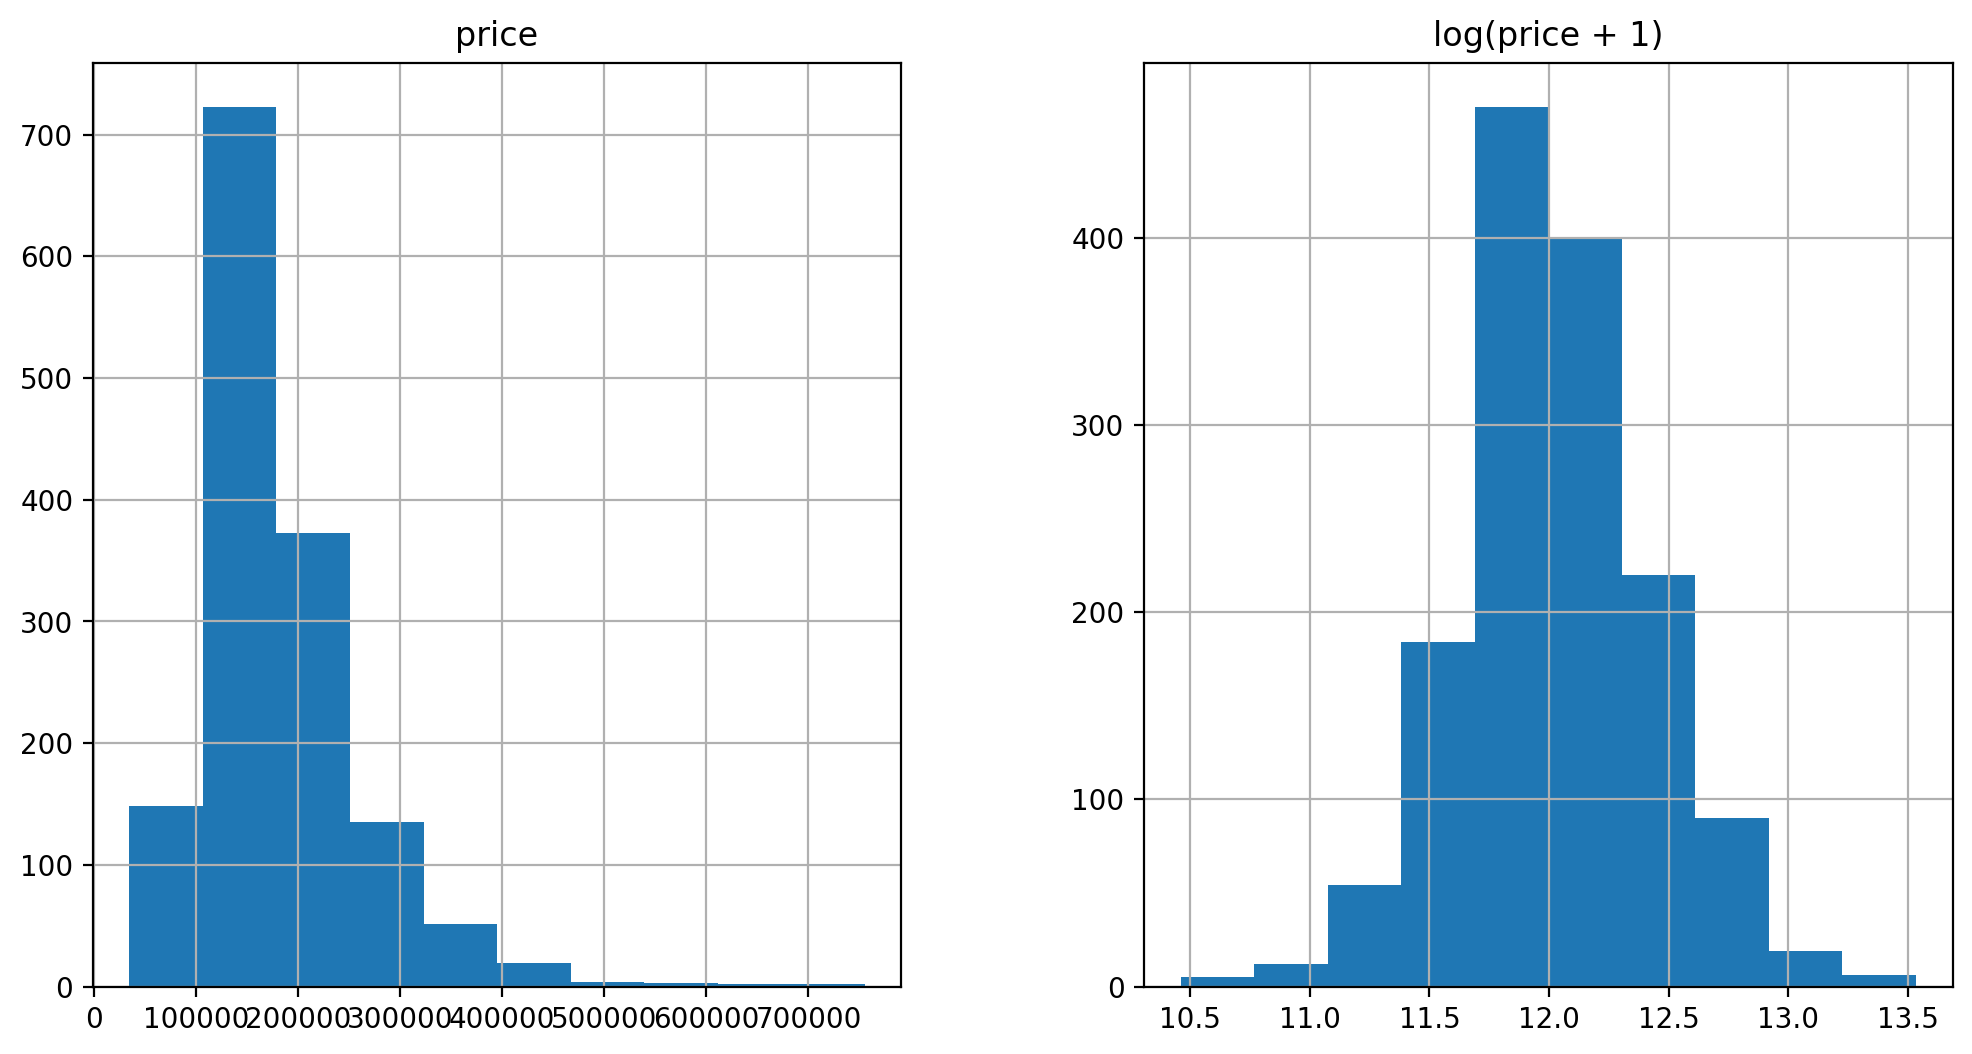

In [12]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist();

In [13]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [14]:
all_data = pd.get_dummies(all_data)

In [15]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [16]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [17]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [18]:
model_ridge = Ridge()

In [19]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]

Text(0, 0.5, 'rmse')

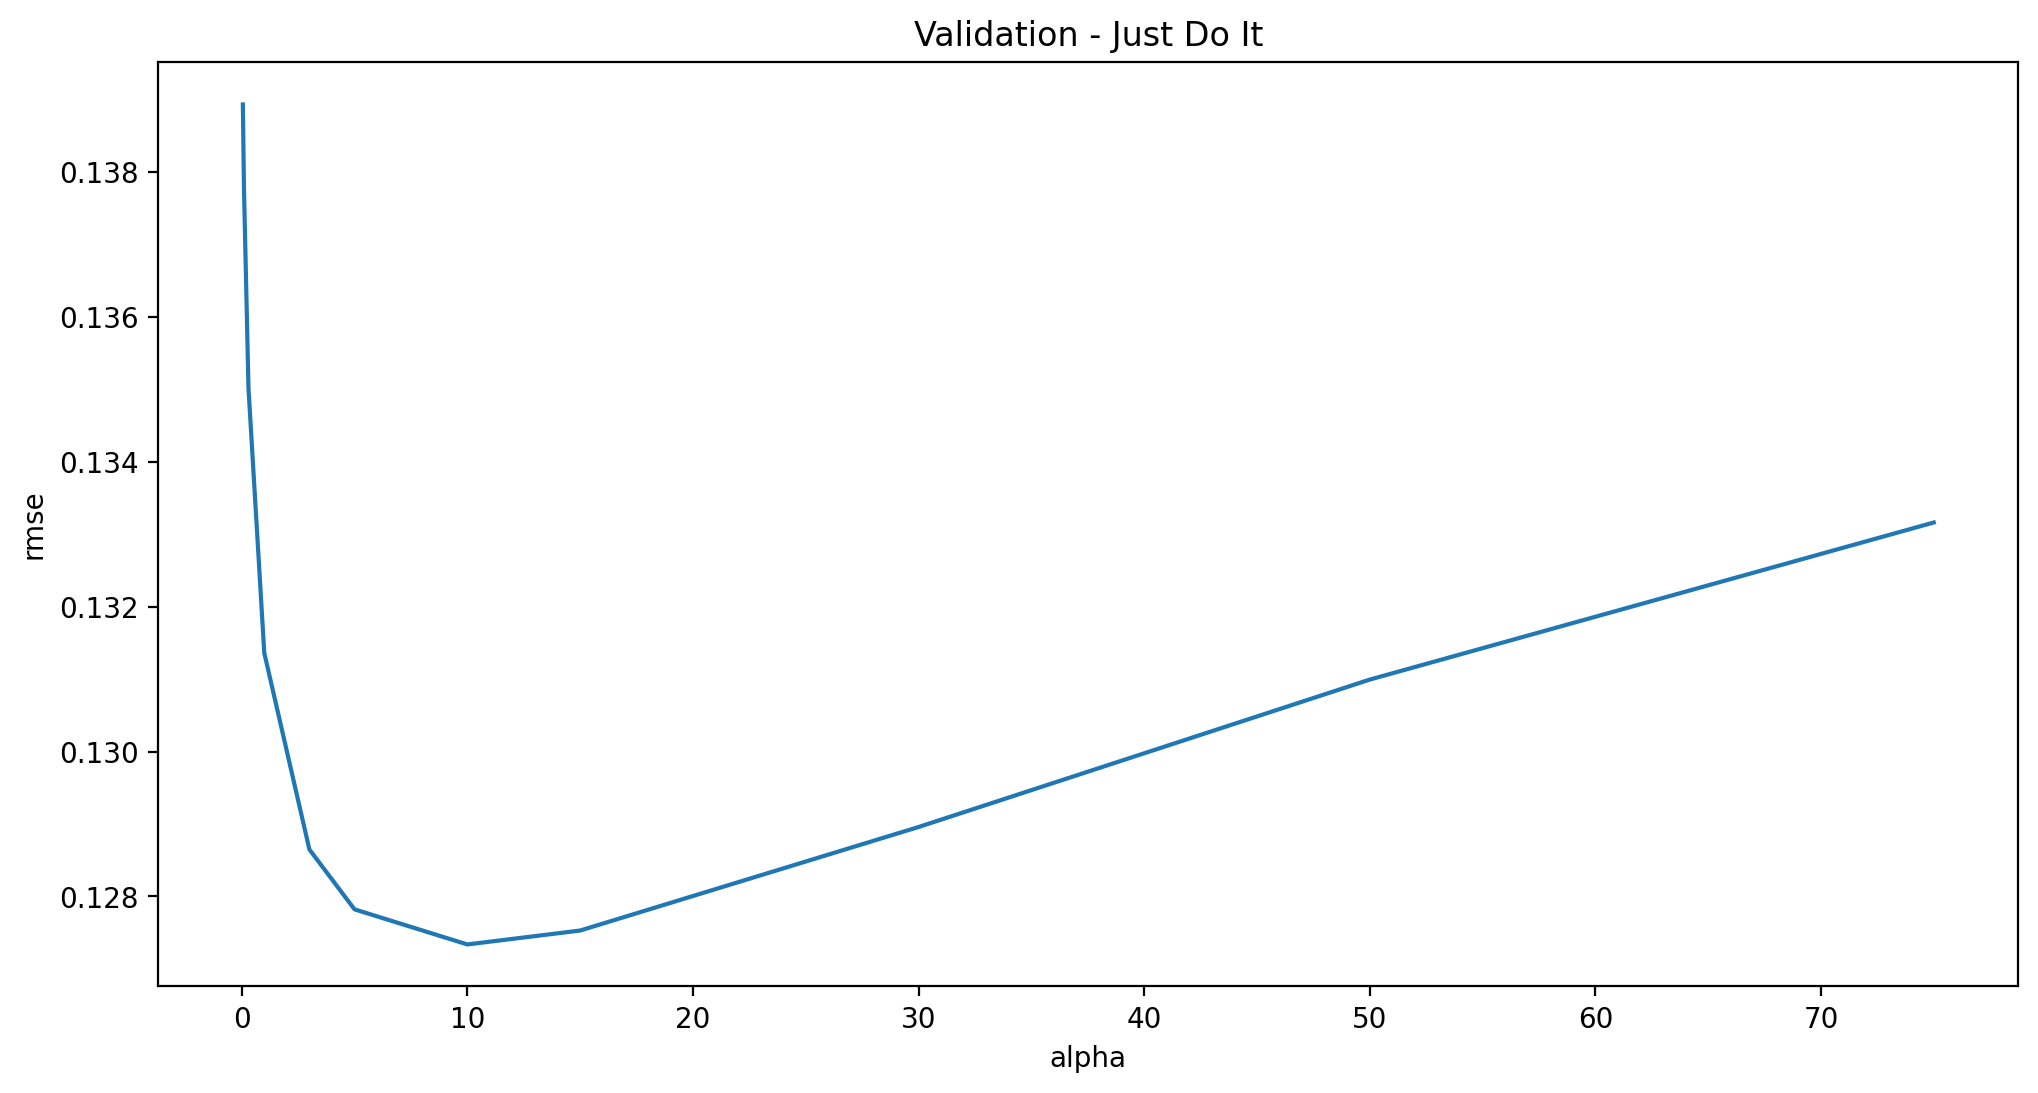

In [21]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [22]:
cv_ridge.min()

0.12733734668670743

In [23]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.12256735885048128

In [24]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

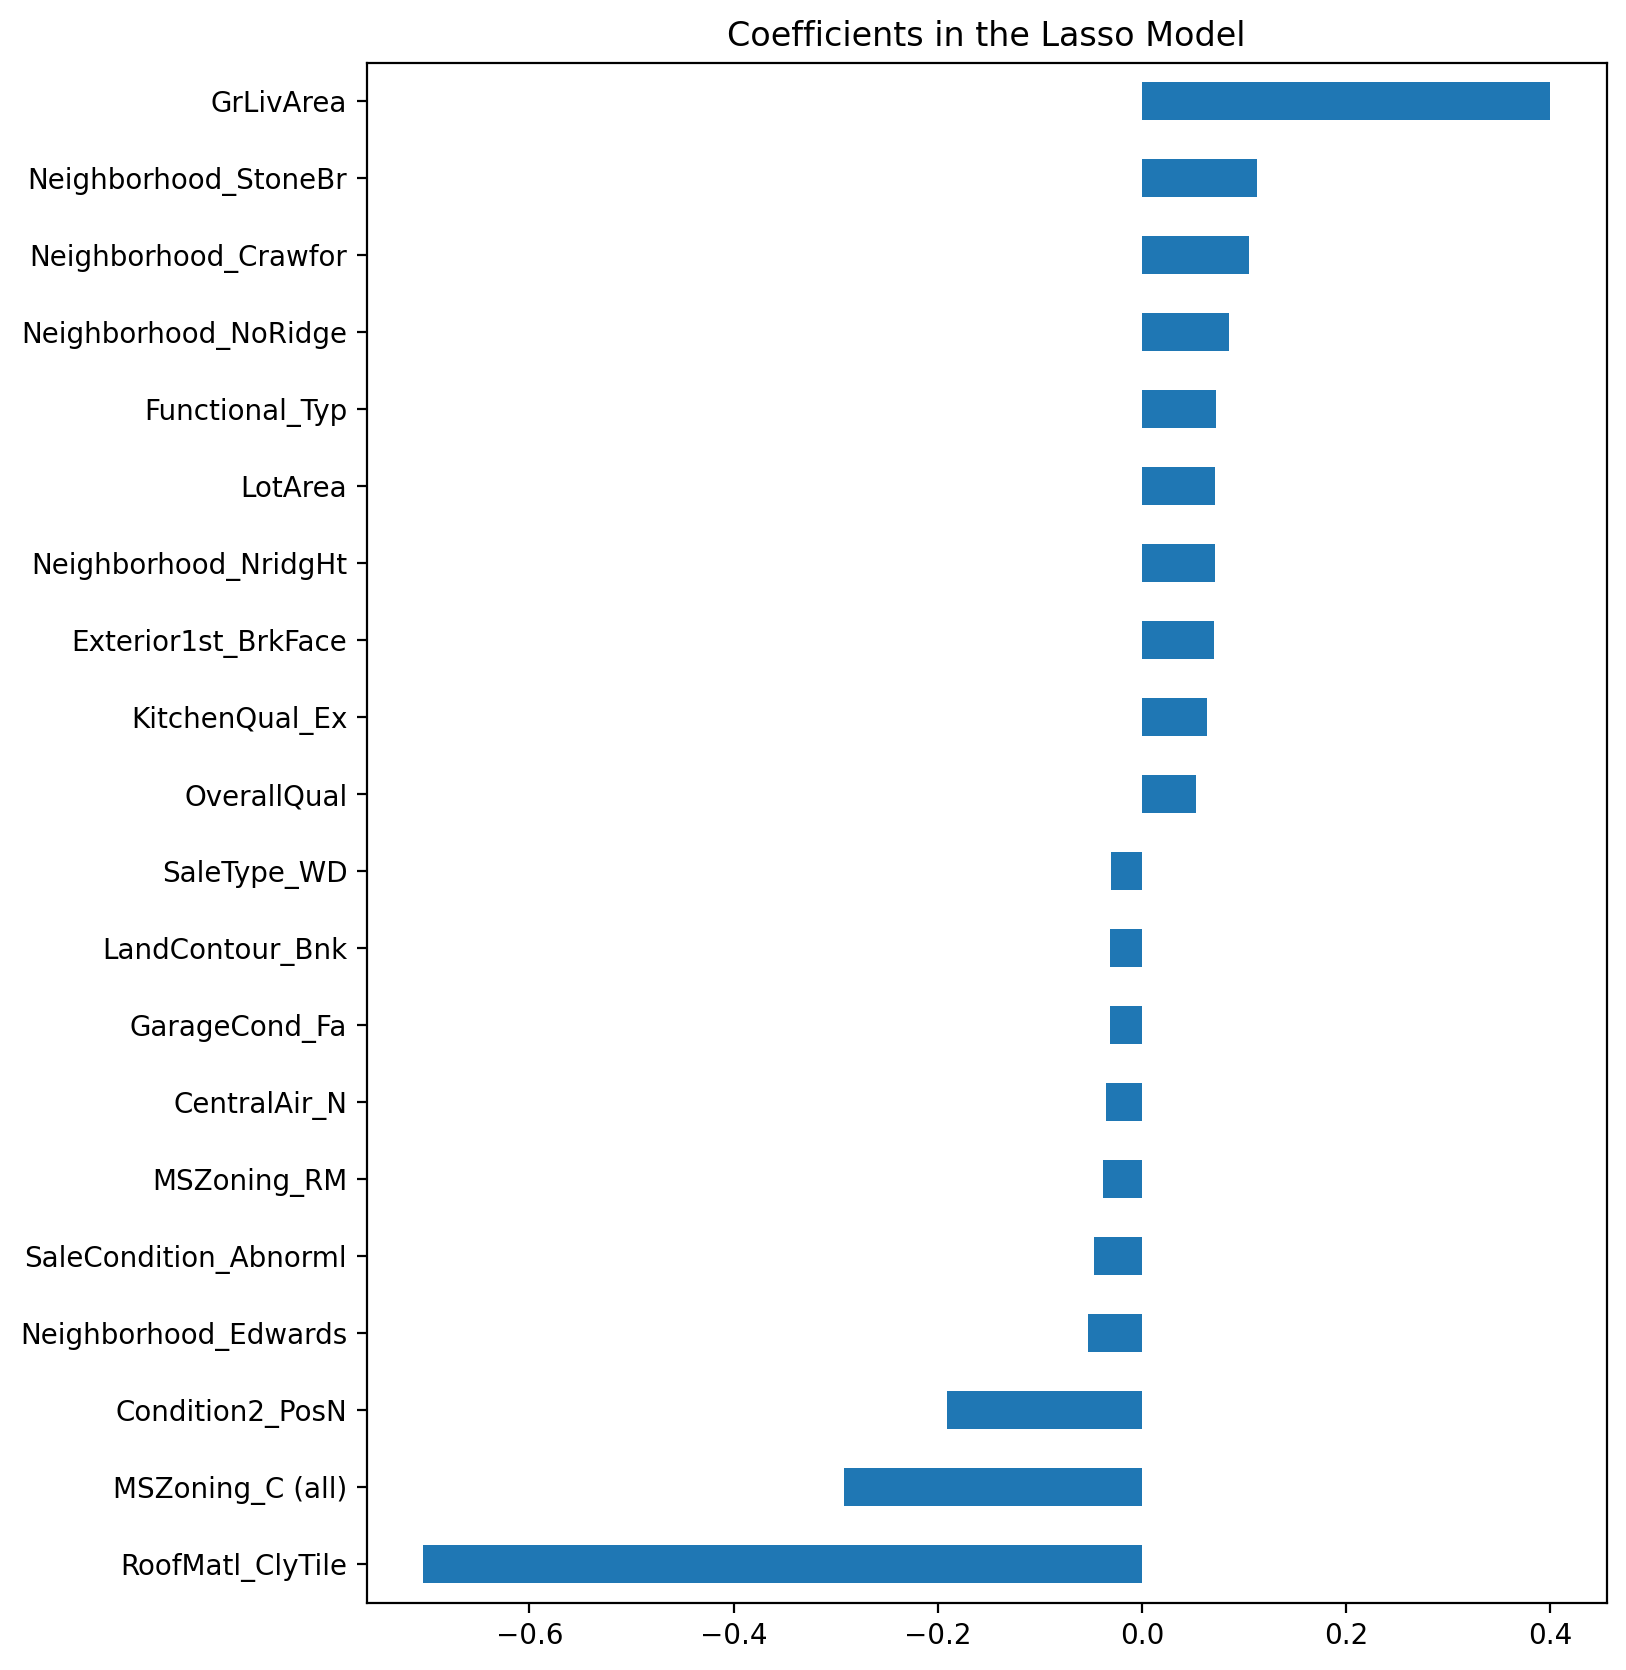

In [26]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

<Axes: xlabel='preds', ylabel='residuals'>

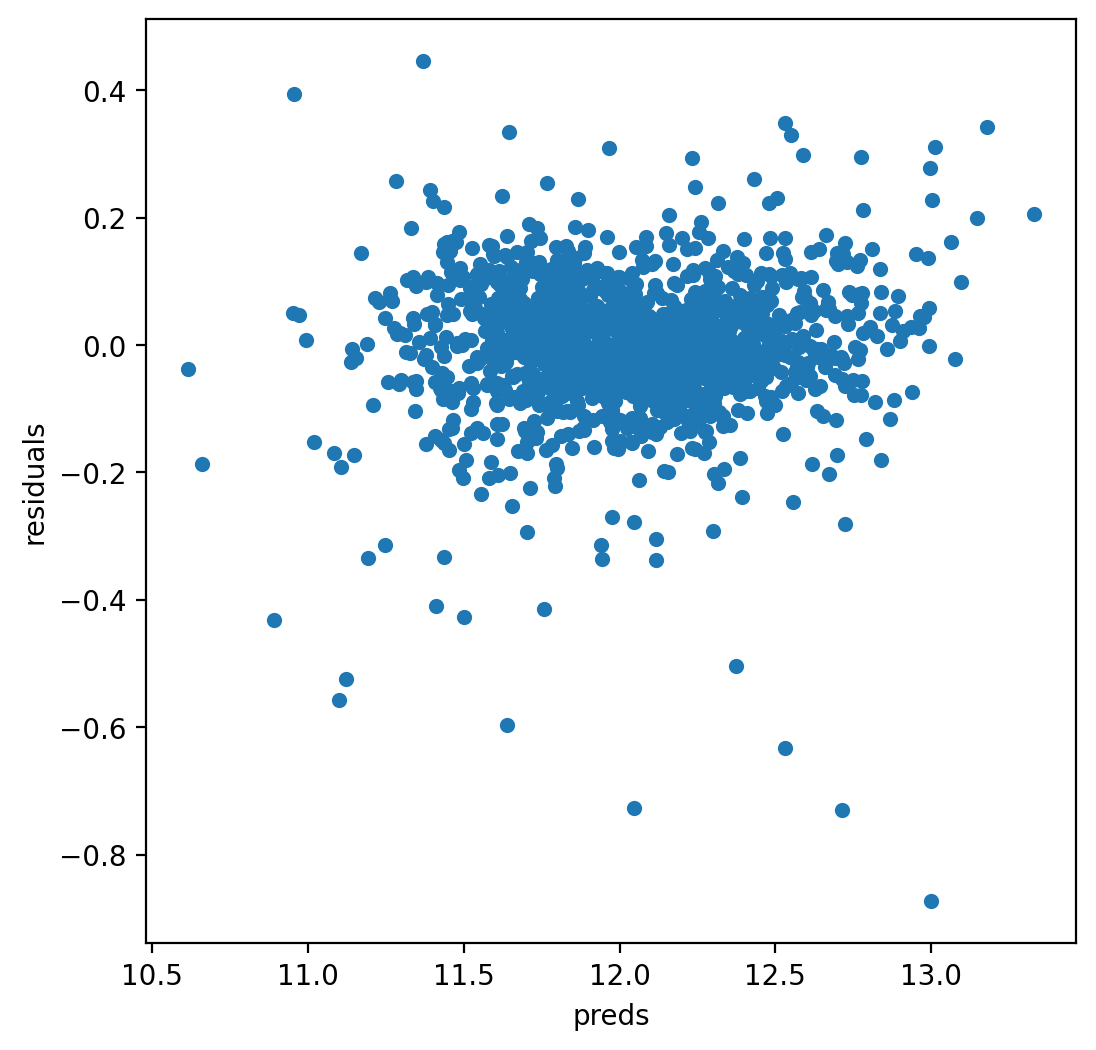

In [27]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [28]:
import xgboost as xgb

In [29]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

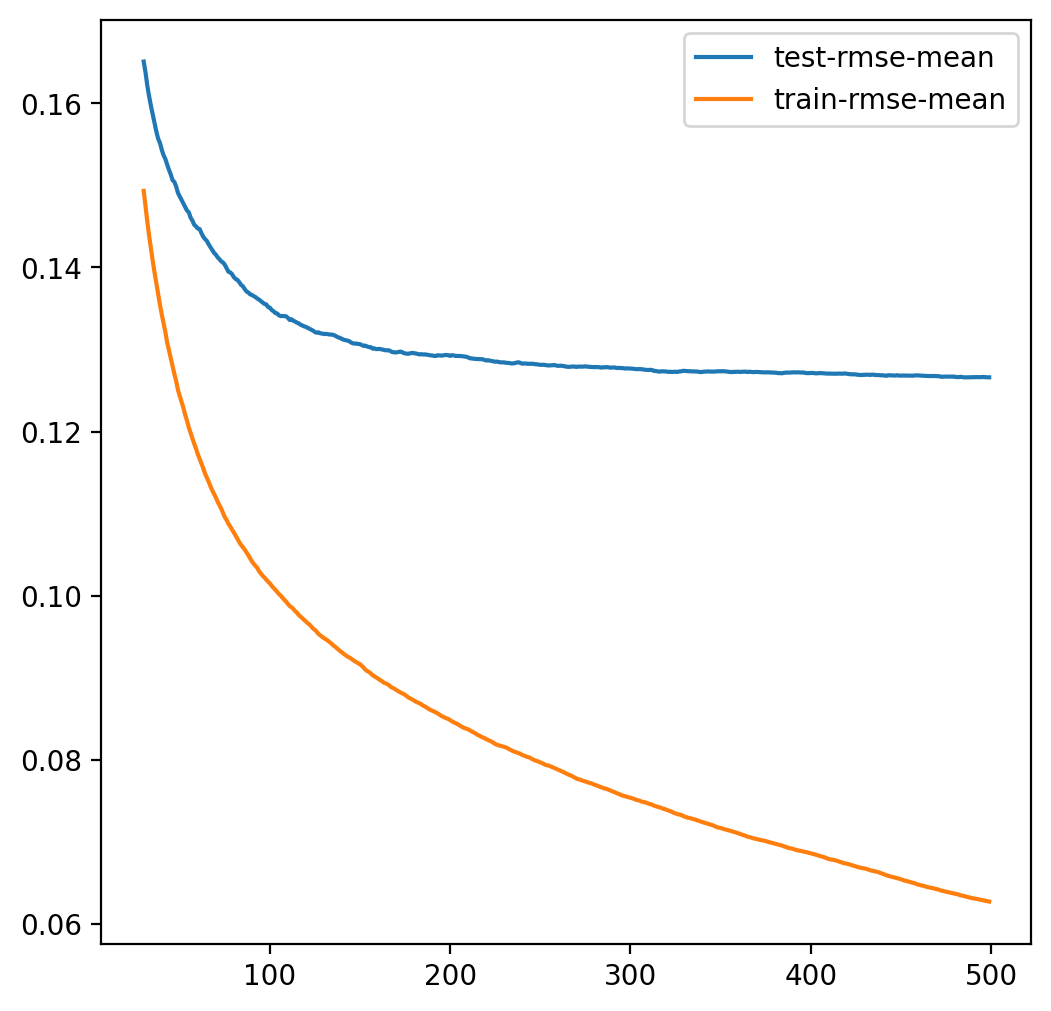

In [32]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot();

In [31]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=360, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

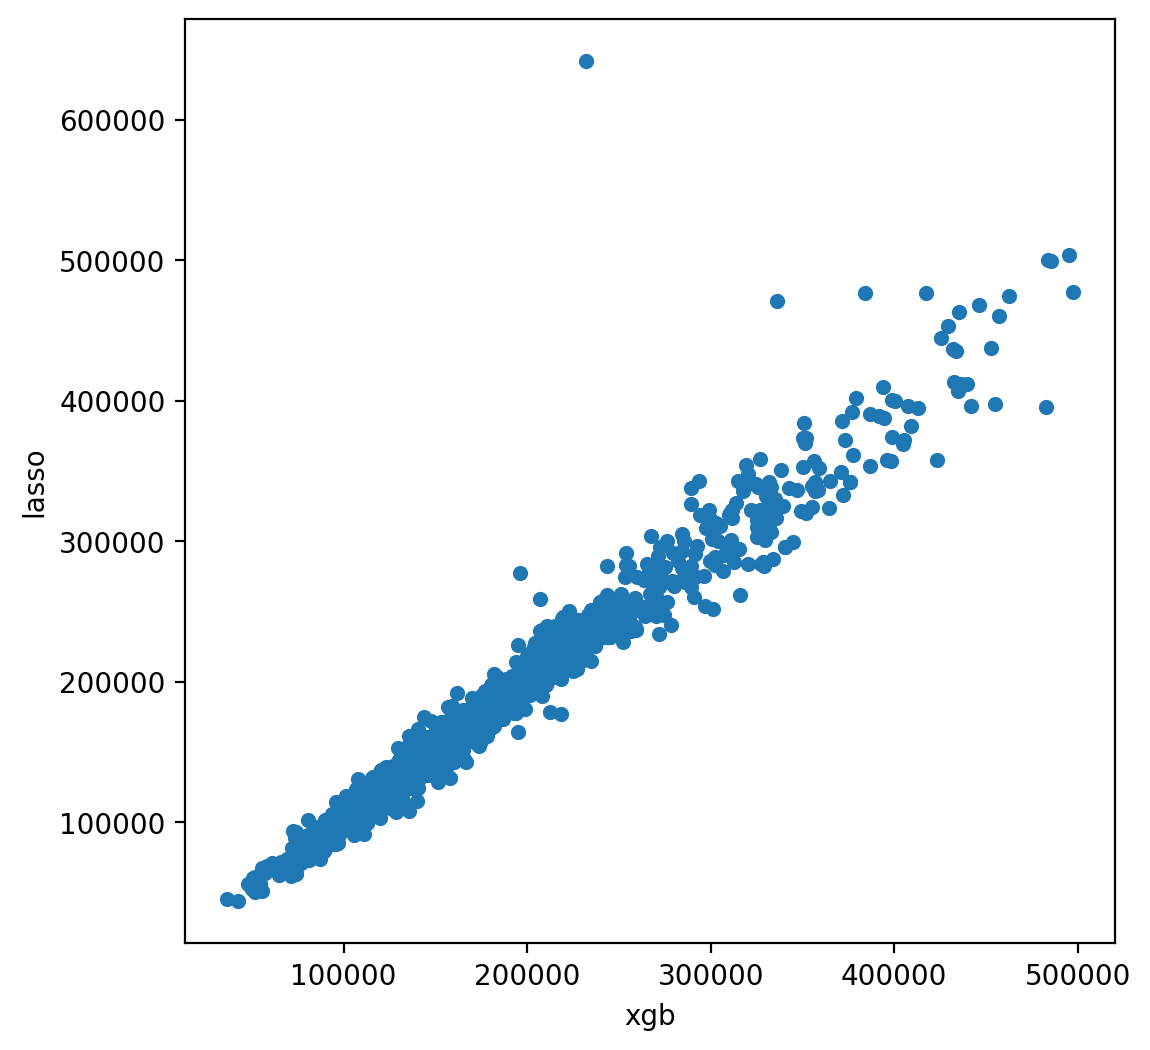

In [34]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter");

In [35]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

HERE SAVE THE RESULTS AS THE SOLUTION.CSV

In [36]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("SOLUTION.csv", index = False)